# Unsupervised Machine Learning and k-means clustering
1. Import libraries
2. Wrangling & cleaning
3. Elbow technique
4. K-means clustering
5. Descriptive statistics of clusters

# 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans
import pylab as pl

In [2]:
# Display graphs without need to call
%matplotlib inline

In [3]:
# Import data
df = pd.read_csv(r'/Users/OldBobJulia/Desktop/CF/Course/6. Advanced Analytics and Dashboard Design/Berlin Airbnb Analysis/02 Data/Prepared data/listing_derivedcolumns.csv')

In [4]:
df.head()

,Unnamed: 0,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Price category,Rental availability,Host type
0,0,Mitte,52.54433,13.39761,Private room,28.0,60,18,0.21,3,101,Low price,Middle term,Commercial host
1,1,Mitte,52.53305,13.40394,Entire home/apt,74.0,90,141,2.20,6,357,Low price,Long term,Commercial host
2,2,Pankow,52.53471,13.41810,Entire home/apt,90.0,62,147,1.14,1,254,Middle price,Long term,Private host
3,3,Tempelhof - Schöneberg,52.49884,13.34940,Private room,29.0,7,27,0.28,1,285,Low price,Long term,Private host
4,4,Friedrichshain-Kreuzberg,52.51163,13.45289,Entire home/apt,79.0,7,135,1.02,1,0,Low price,Short term,Private host


In [5]:
# Drop Unnamed
df = df.drop(columns = ['Unnamed: 0'])

In [6]:
df.shape

(19095, 13)

# 2. Wrangling & cleaning

In [7]:
# Keep only non categorical columns for k-means clustering
columns = ["price", "minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365"]

In [8]:
df = df[columns]

In [9]:
df.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,28.0,60,18,0.21,3,101
1,74.0,90,141,2.20,6,357
2,90.0,62,147,1.14,1,254
3,29.0,7,27,0.28,1,285
4,79.0,7,135,1.02,1,0


In [10]:
# Check for missings
df.isnull().sum()

price                                0
minimum_nights                       0
number_of_reviews                    0
reviews_per_month                 4155
calculated_host_listings_count       0
availability_365                     0
dtype: int64

Reviews per month is missing 4155 values. Previously, I had decided to leave them.

However, k-means will not work with NaN values, so I will impute the mean.

In [11]:
df['reviews_per_month'].mean()

0.7182737617135306

In [12]:
df['reviews_per_month'].fillna(0.72, inplace=True)

In [13]:
df.isnull().sum()

price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [14]:
# Check dups
dups = df.duplicated()

In [15]:
dups.shape

(19095,)

There are no duplicates

In [16]:
# Check summary stats
df.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,19095.00000,19095.000000,19095.000000,19095.000000,19095.000000,19095.000000
mean,72.08474,9.105944,21.637078,0.718649,3.135847,91.271694
std,93.21170,33.635956,48.670427,1.278386,7.773246,127.645330
min,8.00000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,35.00000,2.000000,1.000000,0.120000,1.000000,0.000000
50%,52.00000,3.000000,4.000000,0.480000,1.000000,0.000000
75%,81.00000,5.000000,17.000000,0.720000,2.000000,175.000000
max,4000.00000,1124.000000,620.000000,94.350000,76.000000,365.000000


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='minimum_nights', ylabel='Density'>

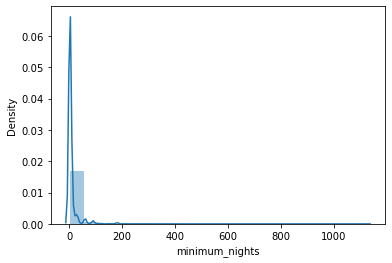

In [17]:
# Check outliers minimum_nights
sns.distplot(df['minimum_nights'], bins=20) 

In [18]:
Min_nights_check = df.loc[df['minimum_nights'] > 730]

In [19]:
Min_nights_check.shape

(9, 6)

There are 9 properties available for over 2 years' rent. It seems legit. 

In [20]:
# Check for mixed data type columns
for col in df.columns.tolist():
  weird = (df[[col]].applymap(type) != df[[col]].iloc[0].apply(type)).any(axis = 1)
  if len (df[weird]) > 0:
    print (col)


There are no mixed data type columns. 

In [21]:
# Check data types
df.dtypes

price                             float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

All variables are within a similar range, no scaling is necessary.

# 3. Elbow technique

In [22]:
num_cl = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in num_cl]

In [23]:
score = [kmeans[i].fit(df).score(df) for i in range(len(kmeans))] 

score

[-545019077.5297748,
 -269607561.70593697,
 -199408761.93144786,
 -164809068.47457823,
 -135052218.83674872,
 -116104617.5347087,
 -103855693.41501738,
 -93743564.83185002,
 -84221049.76814622]

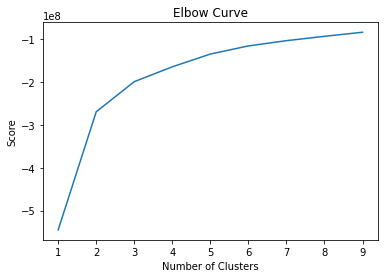

In [24]:
# Plot this curve

pl.plot(num_cl,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

The optimal number of clusters is 3.

# 4. K-means clustering

In [31]:
# Create k-means object
kmeans = KMeans(n_clusters = 3, n_jobs = -1) 

In [32]:
# Fit it to data
kmeans.fit(df)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=3, n_jobs=-1)

In [33]:
# Check clusters in df
df['clusters'] = kmeans.fit_predict(df)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [34]:
df.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,clusters
0,28.0,60,18,0.21,3,101,0
1,74.0,90,141,2.20,6,357,1
2,90.0,62,147,1.14,1,254,1
3,29.0,7,27,0.28,1,285,1
4,79.0,7,135,1.02,1,0,0


In [35]:
# Check the cluster counts
df['clusters'].value_counts()

0    13655
1     5429
2       11
Name: clusters, dtype: int64

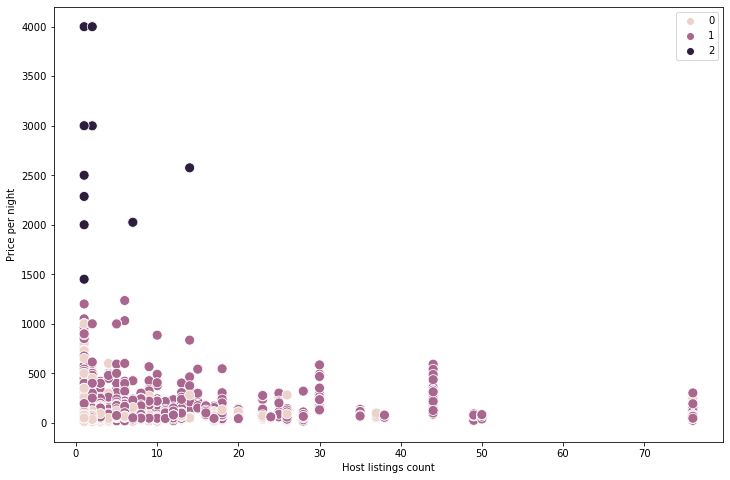

In [36]:
# Plot clusters for price and host listings count variables 

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df['calculated_host_listings_count'], y=df['price'], hue=kmeans.labels_, s=100) 

ax.grid(False) 
plt.xlabel('Host listings count') 
plt.ylabel('Price per night')
plt.show()

Price seems to play a role in the difference between clusters 2 and the rest. 

Clusters 0 and 1 all have prices below 1300.

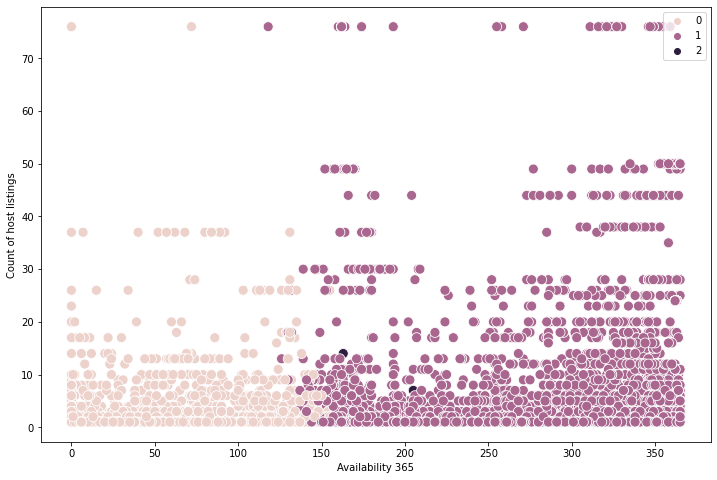

In [37]:
# Plot clusters for availability and host listings count 

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df['availability_365'], y=df['calculated_host_listings_count'], hue=kmeans.labels_, s=100) 

ax.grid(False) 
plt.xlabel('Availability 365') 
plt.ylabel('Count of host listings')
plt.show()

We can see that availability plays a role in the differenciation between clusters 0 and 1.

Cluster 0 goes to 150 and cluster 1 starts at 130. 

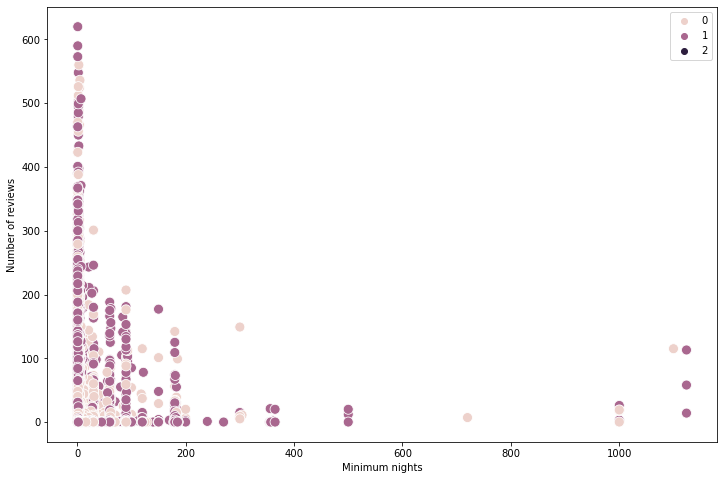

In [38]:
# Plot clusters for number of reviews and minimum nights variables 

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df['minimum_nights'], y=df['number_of_reviews'], hue=kmeans.labels_, s=100) 

ax.grid(False) 
plt.xlabel('Minimum nights')
plt.ylabel('Number of reviews')
plt.show()

Variables number of reviews nor minimum nights play a big role in the differentiation between clusters.

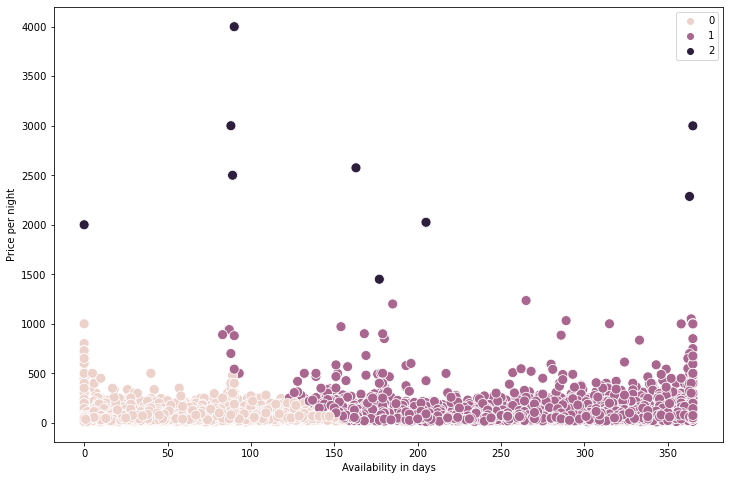

In [39]:
# Plot clusters for price and availability variables 

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df['availability_365'], y=df['price'], hue=kmeans.labels_, s=100) 

ax.grid(False) 
plt.xlabel('Availability in days')
plt.ylabel('Price per night')
plt.show()

In this plot we can see clearly the differences between the clusters. 

Cluster 0 contains properties available up to 155 nights and with a general price range between 0 and 250, with a peak at 1000 EUR / night.

Cluster 1 includes stays starting at 85 and up to 365 nights with a price range between 0 and 1250. 

Cluster 2 only includes properties at more than 1400 EUR / night. 

# 5. Descriptive statistics of clusters

In [40]:
df.loc[df['clusters'] == 2, 'cluster'] = 'dark purple'
df.loc[df['clusters'] == 1, 'cluster'] = 'purple'
df.loc[df['clusters'] == 0, 'cluster'] = 'pink'

In [41]:
df.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,clusters,cluster
0,28.0,60,18,0.21,3,101,0,pink
1,74.0,90,141,2.20,6,357,1,purple
2,90.0,62,147,1.14,1,254,1,purple
3,29.0,7,27,0.28,1,285,1,purple
4,79.0,7,135,1.02,1,0,0,pink


In [42]:
df['cluster'].value_counts(dropna=False)

pink           13655
purple          5429
dark purple       11
Name: cluster, dtype: int64

In [43]:
# Check descriptive statistics of different clusters 
df.groupby('cluster').agg({'price':['mean', 'median'], 
                         'minimum_nights':['mean', 'median'], 
                         'number_of_reviews':['mean', 'median'],
                        'calculated_host_listings_count':['mean', 'median'],
                          'availability_365':['mean', 'median']})

price         minimum_nights        number_of_reviews  \
                    mean  median           mean median              mean   
cluster                                                                    
dark purple  2623.636364  2500.0      17.454545      1          3.818182   
pink           59.984239    49.0       6.461150      3         15.302307   
purple         97.350033    70.0      15.741205      2         37.606373   

                   calculated_host_listings_count        availability_365  \
            median                           mean median             mean   
cluster                                                                     
dark purple      2                       3.454545      1       166.818182   
pink             3                       1.575467      1        16.774735   
purple           7                       7.059864      2       278.493093   

                    
            median  
cluster             
dark purple    163  
pink             0  
purple         297

The descriptive statistics provide the following insights, which can be built on:
- generally, the clusters have segmented the properties in terms of price range into low (pink), medium (purple) and high (dark purple)

The cluster analysis has effectively found the difference between private and commercial hosts. We can see this in: 

- the mean of the calculated host listings count for pink is below 2, so remains within what is reasonable for a private host,

- the mean of the calculated host listings count for purple is over 7 and the median at 2 sharp, clearly showing that a majority of hosts in this segment have at least 2 properties,

- the mean of the numbers of reviews of purple more than doubles the one of pink, further pointing towards many rentals resulting in more reviews,

- finally, the pink segment has a median availability per year of 0 compared to 297 of the purple segment, showing that private hosts set their availability to 0 during the Covid period, very likely because they live in their apartment and could therefore not rent it out.

In [44]:
# Set path 
path = r'/Users/OldBobJulia/Desktop/CF/Course/6. Advanced Analytics and Dashboard Design/Berlin Airbnb Analysis' 

In [47]:
# Export 
df.to_csv(os.path.join(path, '02 Data','Prepared Data', 'listing_for_kmeans.csv'))